# <center>Дашборд для Яндекс.Дзен</center>

## Описание проекта

В данном проекте рассматривается работа с Яндекс.Дзен, которая заключается в анализе пользовательского взаимодействия с карточками статей.

Каждую карточку определяют её тема и источник (у него тоже есть тема). 

Пользователей системы характеризует возрастная категория.

Есть три способа взаимодействия пользователей с системой:

- Карточка отображена для пользователя (show);
- Пользователь кликнул на карточку (click);
- Пользователь просмотрел статью карточки (view).


<b>Задачи</b>: 
- автоматизация процесса анализа пользовательского взаимодействия с карточками статей;
- создать дашборд, который отвечает на следующие вопросы:
    1. Сколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
    2. Как много карточек генерируют источники с разными темами?
    3. Как соотносятся темы карточек и темы источников?

## Краткое ТЗ:
<b>Бизнес-задача</b>: анализ взаимодействия пользователей с карточками Яндекс.Дзен;

<b>Частота использования дашборд</b>: не реже, чем раз в неделю;

<b>Основной пользователь дашборда</b>: менеджеры по анализу контента;

<b>Состав данных для дашборда</b>:

- история событий по темам карточек (два графика - абсолютные числа и процентное соотношение);
- разбивка событий по темам источников;
- таблица соответствия тем источников темам карточек;

<b>Параметры данных для группировки</b>:

- Дата и время;
- Тема карточки;
- Тема источника;
- Возрастная группа;

<b>Характер данных</b>:

- История событий по темам карточек — абсолютные величины с разбивкой по минутам;
- Разбивка событий по темам источников — относительные величины (% событий);
- Соответствия тем источников темам карточек - абсолютные величины;

<b>Важность</b>: все графики имеют равную важность;

<b>Источники данных для дашборда</b>: агрегирующая таблица dash_visits со структурой:
- record_id — первичный ключ,
- item_topic — тема карточки,
- source_topic — тема источника,
- age_segment — возрастной сегмент,
- dt — дата и время,
- visits — количество событий.

Таблица хранится в специально подготовленной для вас базе данных zen;

<b>Частота обновления данных</b>: один раз в сутки, в полночь по UTC;

<b>Макет дашборда</b>:


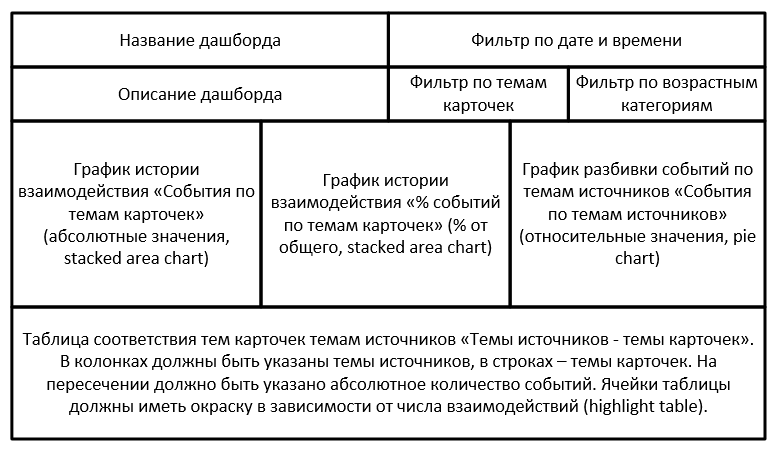

## Загрузка данных

In [1]:
#pip install kaleido

In [2]:
# импортируем библиотеки
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [3]:
#загрузка данных
try:
    df = pd.read_csv(r'C:\Users\Евгения\python\Projects\Dzen\df_dzen.csv')
except:
    print('Ошибка загрузки данных')

df.head()

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27


In [4]:
# общая информация по данным
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   record_id     30745 non-null  int64 
 1   item_topic    30745 non-null  object
 2   source_topic  30745 non-null  object
 3   age_segment   30745 non-null  object
 4   dt            30745 non-null  object
 5   visits        30745 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


In [5]:
#проверка на явные дубликаты
df.duplicated().sum()

0

В полученных данных 30745 строк, пропусков и дубликатов нет, типы данных корректны. Трансформация данных не нужна, они корректны для создания дашборда в Tableau

In [6]:
#общее количество событий
total_visits = df['visits'].sum()
print('Общее количество событий:', total_visits)

Общее количество событий: 310207


## Исследование данных

### Количество взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек

In [7]:
#сводная таблица количества событий по времени и по темам карточек 
pt1=(df.pivot_table(index = 'item_topic', columns = 'dt', values = 'visits', aggfunc = {'sum'}).droplevel(level=0, axis =1)
     .rename(columns = {'':'item_topic'})
     .rename_axis(None, axis=1))
pt1['total'] = pt1.sum(axis = 1)
pt1 = pt1.sort_values('total', ascending = False)
pt1.loc['sum',:] = pt1.sum(axis = 0)
pt1.style.format("{:.0f}")

,2019-09-24 18:28:00,2019-09-24 18:29:00,2019-09-24 18:30:00,2019-09-24 18:31:00,2019-09-24 18:32:00,2019-09-24 18:33:00,2019-09-24 18:34:00,2019-09-24 18:35:00,2019-09-24 18:52:00,2019-09-24 18:53:00,2019-09-24 18:54:00,2019-09-24 18:55:00,2019-09-24 18:56:00,2019-09-24 18:57:00,2019-09-24 18:58:00,2019-09-24 18:59:00,2019-09-24 19:00:00,total
item_topic,,,,,,,,,,,,,,,,,,
Наука,66,116,145,153,177,112,47,7,91,144,991,2308,3823,4277,4372,3720,1187,21736
Отношения,51,123,150,145,168,120,52,9,66,147,933,2190,3614,4133,4145,3431,1189,20666
Интересные факты,56,134,173,179,185,99,45,9,64,153,902,2053,3499,3903,3910,3475,1103,19942
Общество,63,107,155,169,164,105,51,11,67,131,886,2146,3390,3723,3897,3431,1144,19640
Подборки,41,106,138,133,155,103,40,14,75,107,831,1925,3112,3381,3520,3051,1040,17772
Россия,40,92,126,147,118,87,46,7,74,115,756,1812,2978,3361,3296,2921,990,16966
Полезные советы,37,75,127,142,128,94,34,17,54,104,724,1606,2590,3047,3039,2711,906,15435
История,43,72,123,125,121,85,32,18,49,105,701,1635,2635,3029,3052,2689,875,15389
Семья,32,79,101,114,110,58,32,5,41,87,535,1259,2121,2378,2287,1977,681,11897


In [8]:
#аналогичная сводная таблица 
pt1_2 = df.groupby(['item_topic', 'dt'], as_index = False).agg({'visits' :'sum'})

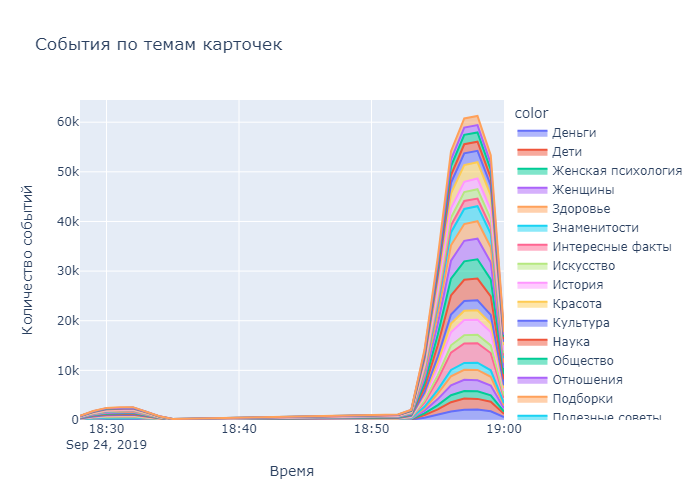

In [9]:
#график событий по карточкам
fig = px.area(x=pt1_2['dt'], 
              y=pt1_2['visits'], 
              color=pt1_2['item_topic'], 
              title = 'События по темам карточек',
               labels={
                     'x': 'Время',
                     'y': 'Количество событий'})

fig.show('png')

### Относительное количество взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек

In [10]:
#сводная таблица относительного количества событий по времени и по темам карточек 
pt2 = pt1.apply(lambda x: x/x['sum']*100)
pt2.style.format("{:.2f}%")

,2019-09-24 18:28:00,2019-09-24 18:29:00,2019-09-24 18:30:00,2019-09-24 18:31:00,2019-09-24 18:32:00,2019-09-24 18:33:00,2019-09-24 18:34:00,2019-09-24 18:35:00,2019-09-24 18:52:00,2019-09-24 18:53:00,2019-09-24 18:54:00,2019-09-24 18:55:00,2019-09-24 18:56:00,2019-09-24 18:57:00,2019-09-24 18:58:00,2019-09-24 18:59:00,2019-09-24 19:00:00,total
item_topic,,,,,,,,,,,,,,,,,,
Наука,7.90%,6.38%,5.94%,5.90%,6.84%,6.49%,6.16%,3.57%,8.18%,7.00%,7.01%,7.06%,7.06%,7.04%,7.14%,6.97%,6.70%,7.01%
Отношения,6.11%,6.77%,6.14%,5.59%,6.49%,6.95%,6.82%,4.59%,5.94%,7.15%,6.60%,6.70%,6.67%,6.80%,6.77%,6.43%,6.72%,6.66%
Интересные факты,6.71%,7.37%,7.08%,6.91%,7.15%,5.74%,5.90%,4.59%,5.76%,7.44%,6.38%,6.28%,6.46%,6.42%,6.38%,6.51%,6.23%,6.43%
Общество,7.54%,5.89%,6.35%,6.52%,6.34%,6.08%,6.68%,5.61%,6.03%,6.37%,6.27%,6.56%,6.26%,6.13%,6.36%,6.43%,6.46%,6.33%
Подборки,4.91%,5.83%,5.65%,5.13%,5.99%,5.97%,5.24%,7.14%,6.74%,5.20%,5.88%,5.89%,5.75%,5.56%,5.75%,5.72%,5.87%,5.73%
Россия,4.79%,5.06%,5.16%,5.67%,4.56%,5.04%,6.03%,3.57%,6.65%,5.59%,5.35%,5.54%,5.50%,5.53%,5.38%,5.47%,5.59%,5.47%
Полезные советы,4.43%,4.13%,5.20%,5.48%,4.95%,5.45%,4.46%,8.67%,4.86%,5.06%,5.12%,4.91%,4.78%,5.01%,4.96%,5.08%,5.12%,4.98%
История,5.15%,3.96%,5.04%,4.82%,4.68%,4.92%,4.19%,9.18%,4.41%,5.10%,4.96%,5.00%,4.86%,4.99%,4.98%,5.04%,4.94%,4.96%
Семья,3.83%,4.35%,4.14%,4.40%,4.25%,3.36%,4.19%,2.55%,3.69%,4.23%,3.78%,3.85%,3.92%,3.91%,3.73%,3.70%,3.85%,3.84%


In [11]:
#удаление из сводной таблицы строки sum и столбца total
pt2_2 = pt2.reset_index().drop(len(pt2)-1).drop(columns = 'total', axis=1)

In [12]:
#список столбцов для преобразования сводной таблицы в строко-ориентированную таблицу 
col_list = list(pt2_2.columns.values)
col_list = col_list[1:len(col_list)]

In [13]:
#преобразования сводной таблицы в строко-ориентированную таблицу 
pt2_2 = pd.melt(pt2_2, id_vars=['item_topic'], value_vars = col_list)
pt2_2 = pt2_2.rename(columns={'variable': 'dt', 'value': 'ratio'})

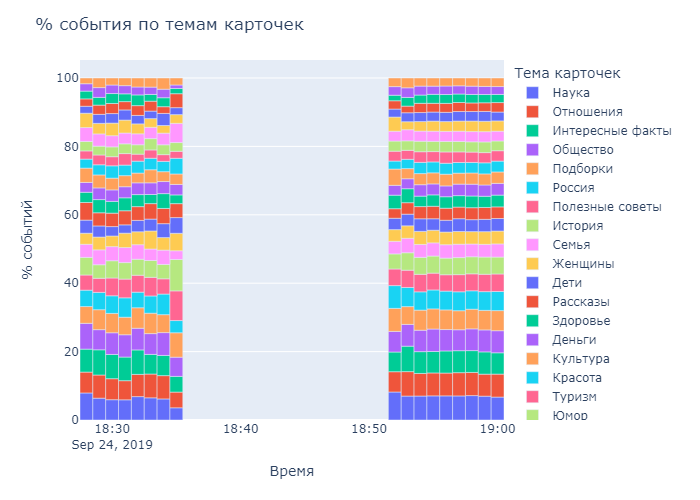

In [14]:
#график % событий по карточкам
fig = px.bar(pt2_2, 
             x = 'dt',
             y = 'ratio',
             color = 'item_topic')
fig.layout.xaxis.update( title = 'Время' )
fig.layout.yaxis.update( title = '% событий' )
fig.update_layout(bargap=0)
fig.update_layout(legend_title='Тема карточек', title = '% события по темам карточек')
fig.show('png')

### Относительное количество взаимодействий пользователей с карточками происходит в системе с разбивкой по темам источников

In [15]:
#сводная таблица взаимодействий по темам источников
pt3 = df.pivot_table(index = 'source_topic', values = 'visits', aggfunc ={'sum'}).sort_values(by = 'sum', ascending = False)
pt3['ratio'] = 100*pt3['sum']/pt3['sum'].sum()
pt3 = pt3.reset_index()
pt3.style.format({'ratio':"{:.3f}%"})

,source_topic,sum,ratio
0,Семейные отношения,33309,10.738%
1,Россия,29831,9.616%
2,Полезные советы,27412,8.837%
3,Путешествия,24124,7.777%
4,Знаменитости,23945,7.719%
5,Кино,20084,6.474%
6,Дети,15243,4.914%
7,История,14628,4.716%
8,Семья,13896,4.480%
9,Здоровье,12831,4.136%


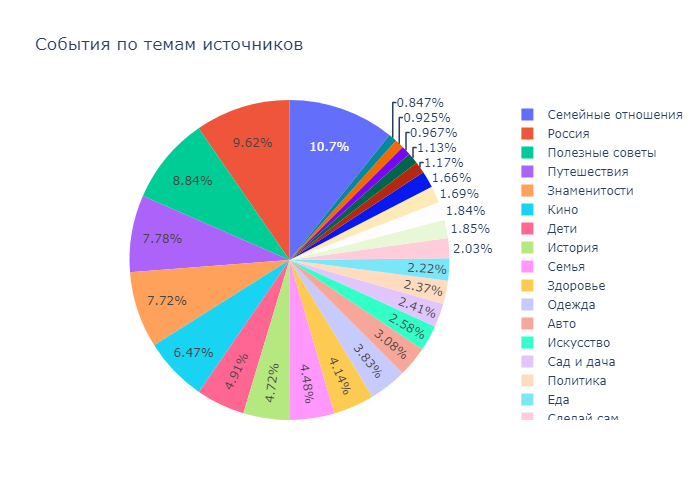

In [16]:
#круговая диаграмма событий по темам карточек
fig = px.pie(pt3, values='sum', names='source_topic', title='События по темам источников')
fig.show('png')

###  Соотношение тем карточек и тем источников

In [17]:
#сводная таблица cоотношений тем карточек и тем источников
pt4=(df.pivot_table(index = 'item_topic', 
                             columns = 'source_topic', 
                             values = 'visits', 
                             aggfunc = {'sum'},
                            fill_value = 0).droplevel(level=0, axis =1)
     .rename(columns = {'':'item_topic'})
     .rename_axis(None, axis=1).style.background_gradient(axis=0, cmap='BuGn'))
pt4

,Авто,Деньги,Дети,Еда,Здоровье,Знаменитости,Интерьеры,Искусство,История,Кино,Музыка,Одежда,Полезные советы,Политика,Психология,Путешествия,Ремонт,Россия,Сад и дача,Сделай сам,Семейные отношения,Семья,Спорт,Строительство,Технологии,Финансы
item_topic,,,,,,,,,,,,,,,,,,,,,,,,,,
Деньги,338,203,859,193,65,591,62,172,271,1042,42,98,1087,949,305,536,362,1132,101,137,696,345,134,68,88,415
Дети,192,228,621,675,346,1444,97,238,455,474,9,320,1541,135,128,431,174,547,633,354,1184,558,21,103,28,53
Женская психология,26,256,613,67,349,546,0,96,181,264,5,466,418,23,463,321,13,660,49,19,2073,759,26,0,39,5
Женщины,156,122,875,348,1022,967,175,485,560,340,45,547,986,78,253,192,67,397,125,223,2270,988,210,56,6,6
Здоровье,232,95,798,558,404,962,57,64,68,156,20,518,2335,121,214,393,145,712,542,548,814,247,197,106,74,19
Знаменитости,29,55,145,36,139,445,12,356,644,408,55,467,178,35,88,299,3,2275,21,6,764,234,433,50,158,59
Интересные факты,1254,145,327,391,2090,720,54,697,1273,1033,325,837,2023,340,449,1448,175,2567,825,341,1323,611,186,234,219,55
Искусство,145,98,639,7,70,1083,164,512,596,1254,223,209,331,121,98,664,172,632,43,128,754,404,54,53,58,4
История,522,114,1047,60,771,921,30,695,636,1091,164,310,859,695,227,2643,168,1491,209,149,1344,696,190,9,286,62


## Вывод

Для анализа взаимодействия пользователей с карточками Яндекс.Дзен были получаны группированные данные с темами карточек и источников, датой/временем и количеством событий. При рассмотрении временного промежутка было принято сократить его в связи с наличием неполных данных. Для дальнейшего анализа выбран промежуток 18:28 - 19:00 24.09.2019 г.

За этот промежуток времени было совершино 310207 событий.

Пик пришелся на 18:58 и составил 61247 событий.

1. <b>Сколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек? </b>

Наиболее популярные темы карточек (количество событий в пиковое время - 18.58):

    - Наука (4372)
    - Отношения (4145)
    - Интересные факты (3910)
    - Общество (3897)
    - Подборки (3520)

Наименее популярные темы карточек (количество событий в пиковое время - 18.58):

    - Знаменитости (1463)
    - Шоу (1485)
    - Женская психология (1518)
    - Психология (1538)
    - Искусство	(1707)
    
	
2. <b>Как много карточек генерируют источники с разными темами?</b>

Наиболее популярные темы источников (количество событий всего):

    - Семейные отношения (10.738%); 
    - Россия (9.616%);
    - Полезные советы (8.837%);
    - Путешествия (7.777%);
    - Знаменитости (7.719%).

Наименее популярные темы источников (количество событий всего):

    - Финансы (0,847%);
    - Музыка (0,9255);
    - Строительство (0.967%);
    - Технологии (1.129%);
    - Интерьеры (1.165%).  


3. <b>Как соотносятся темы карточек и темы источников?</b>

Наиболее популярные сочетания тем источников и карточек (количество событий):

    - Путешествия-Рассказы (4587);
    - Россия-Общество (3471);
    - Кино-Наука (3279);
    - Россия-Россия (2847);
    - Полезные советы-Подборки (2795).

Сочетания, которые не используются:

    - Интерьеры-Женская психология
    - Строительство-Женская психология
    - Сад и дача-Шоу
    - Сделай сам-Шоу
    - Технология-Шоу
    - Строительство-Скандалы

## Ссылка на дашборд:

<a href="https://public.tableau.com/views/Dashbord_Dzen_16861427627560/Dashboard_Dzen?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link">Дашборд</a>


## Ссылка на презентацию

<a href="https://disk.yandex.ru/i/1kGh9KbPbnUDtA">Презентация</a>